In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import rc_style, pltlabel
rc_style(font_size=14)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ising model and scaling correlation analysis
Hamiltonian – rate of change in time of the condition of a dynamic physical system, or total energy in the system – is given by

\\[ H = -J\sum_{ij} s_is_j \\] 

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Furnstahl:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf

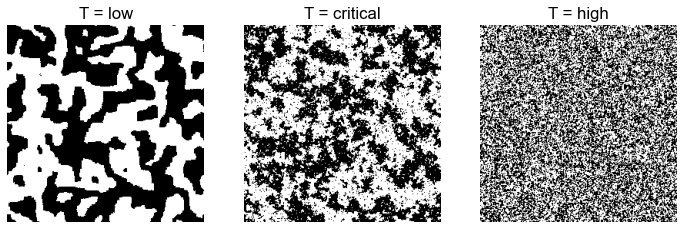

In [34]:
plt.figure(figsize=(12,4))
for i, temp in enumerate([0.1, 'critical', 5]):
    plt.subplot(1,3,i+1)
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    plt.imshow(grid[499], cmap='gray') # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}')
    plt.axis('off')

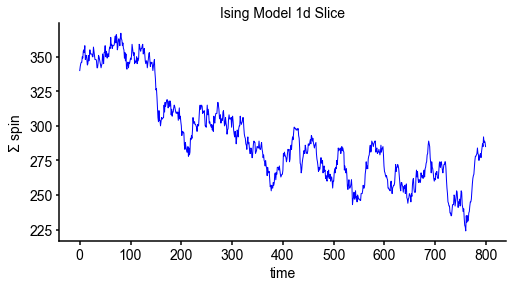

In [26]:
ising_raster = ising.metro_ising(N=650, T='critical', plot=False, runtime=1000)
## take a slice to imitate shape of mouse recordings
ising_raster_slice = pd.DataFrame(ising_raster[200:][:,325]) # shape (800, 650)

plt.figure(figsize=(8,4))
plt.plot(np.sum(ising_raster_slice.T), 'blue', lw=1)
pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
# plt.savefig('../fig/ising/ts_sample.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


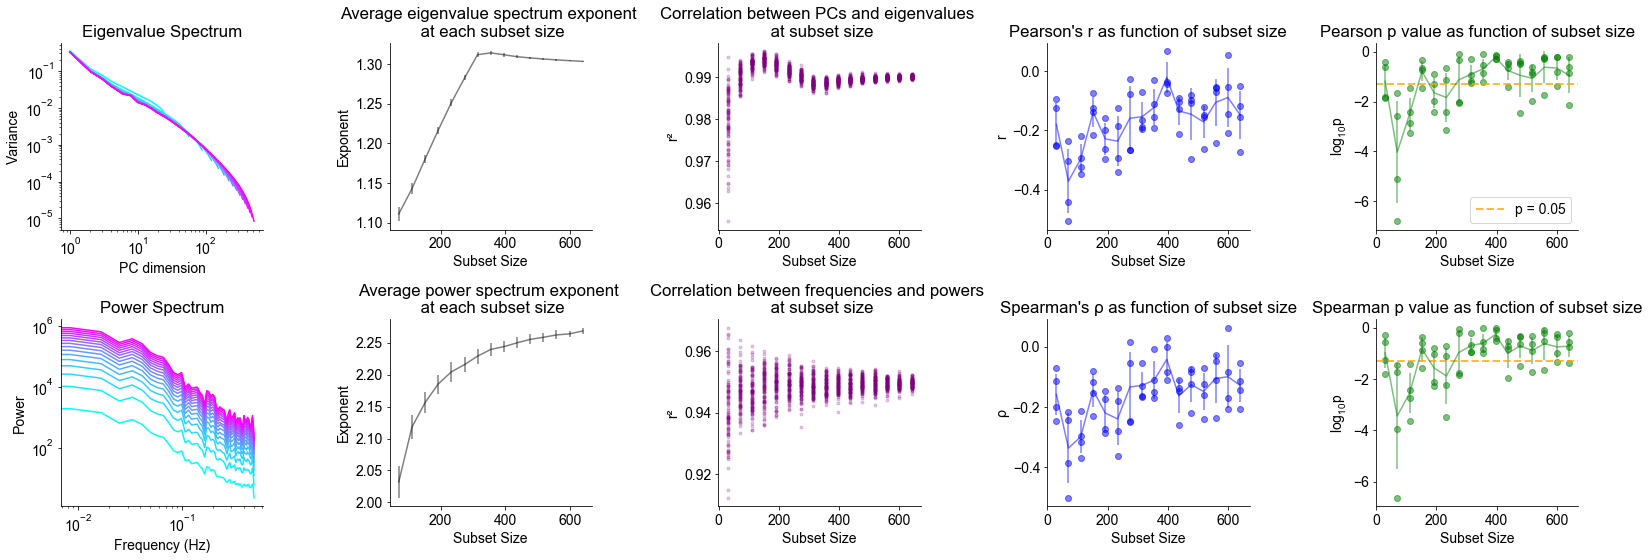

In [78]:
# TODO 
   # this cell won't run due to changes in ramsey output

subsetsizes = np.linspace(30,640,16, dtype=int)
N_ITERS = 95 
N_PC = 0.8
F_RANGE = [0,0.4]
PC_RANGE = [0,None] # not used, originally 0.7 why?
decomp_arr = []
for i in range(4):
    eigs, pows, pca_m, s_r2, ft_m,\
    t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(ising_raster_slice.T, subsetsizes, 
                                                    n_iters=N_ITERS, n_pc=N_PC, f_range=F_RANGE)
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])
decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subsetsizes, s_r2, t_r2, n_iters, n_pc, F_RANGE, PC_RANGE, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

## loading data simulated from cluster

Iterated 5 times for each temperature in: 0.50, 1.00, 1.27, 1.47, 1.67, 1.87, 2.07, 2.27, 2.47, 2.67, 2.87, 3.07, 3.27, 5.00

In [35]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/expSIM2', kind='sim')

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


# summary heatmap

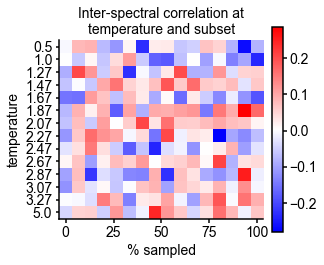

In [41]:
corr_mat = [sim_data[temp]['data']['pearson_corr'].mean(0) 
                    for temp in sim_data.keys()]
plt.figure(figsize=(4,4))
plt.imshow(corr_mat, 'bwr')
plt.xticks(ticks=np.linspace(0,15,5) , labels=np.linspace(0,100,5,dtype=int))#subset_sizes/max(subset_sizes))
plt.yticks(ticks=range(len(sim_data.keys())), labels=list(map(float, sim_data.keys())))
plt.ylim((len(sim_data.keys())-0.5, -0.5)) # weird bug: imshow y axis gets cut off so have to force ylim
plt.colorbar(fraction=0.046, pad=0.04)
pltlabel('Inter-spectral correlation at\ntemperature and subset', '% sampled','temperature')
# plt.savefig('../fig/ising/corr_heatmap.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

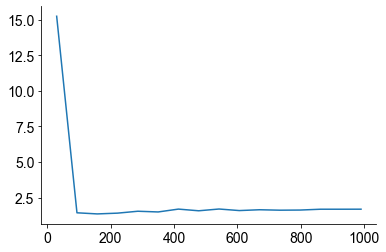

In [41]:
plt.plot(subset_sizes, sim_data['1.00']['espec_exp'][0])

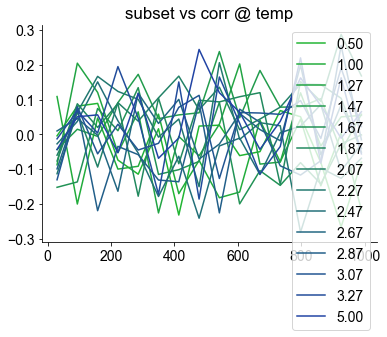

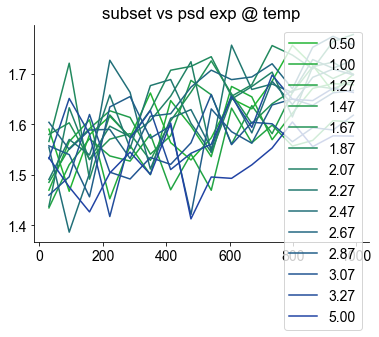

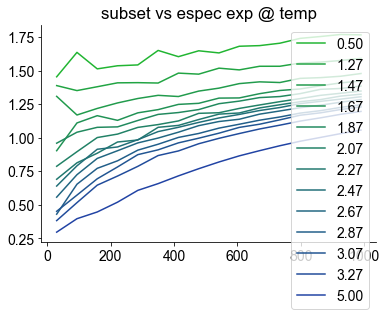

In [39]:
from matplotlib.colors import LinearSegmentedColormap

subset_sizes = sim_data['1.00']['meta']['subsetsizes'] #arbitrary temperature
cmap = LinearSegmentedColormap.from_list('mycmap', ['#21b532', '#2132b5'])(np.linspace(0, 1, len(subset_sizes)))
for i, temp in enumerate(sim_data.keys()):
    plt.plot(subset_sizes, sim_data[temp]['data']['pearson_corr'].mean(0), color=cmap[i], label=temp)
pltlabel('subset vs corr @ temp', '','')
plt.legend()

plt.figure()
for i, temp in enumerate(sim_data.keys()):
    plt.plot(subset_sizes, sim_data[temp]['data']['psd_exp'][0], color=cmap[i], label=temp)
pltlabel('subset vs psd exp @ temp','','')
plt.legend()

plt.figure()
for i, temp in enumerate(sim_data.keys()):
    if temp == '1.00': continue # this one is messed up for some reason
    plt.plot(subset_sizes, sim_data[temp]['data']['espec_exp'][0], color=cmap[i], label=temp)
pltlabel('subset vs espec exp @ temp','','')
plt.legend()